In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# if torch.backends.mps.is_available():
#     device = torch.device("mps")
# elif torch.cuda.is_available():
#     device = torch.device("cuda")
# else:
device = torch.device("cpu")
    
print(device)

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

cpu


In [2]:
# Read in a image from torchvision
import torchvision
img = torchvision.io.read_image("image.jpg")
print(img.shape)


torch.Size([3, 4000, 6000])


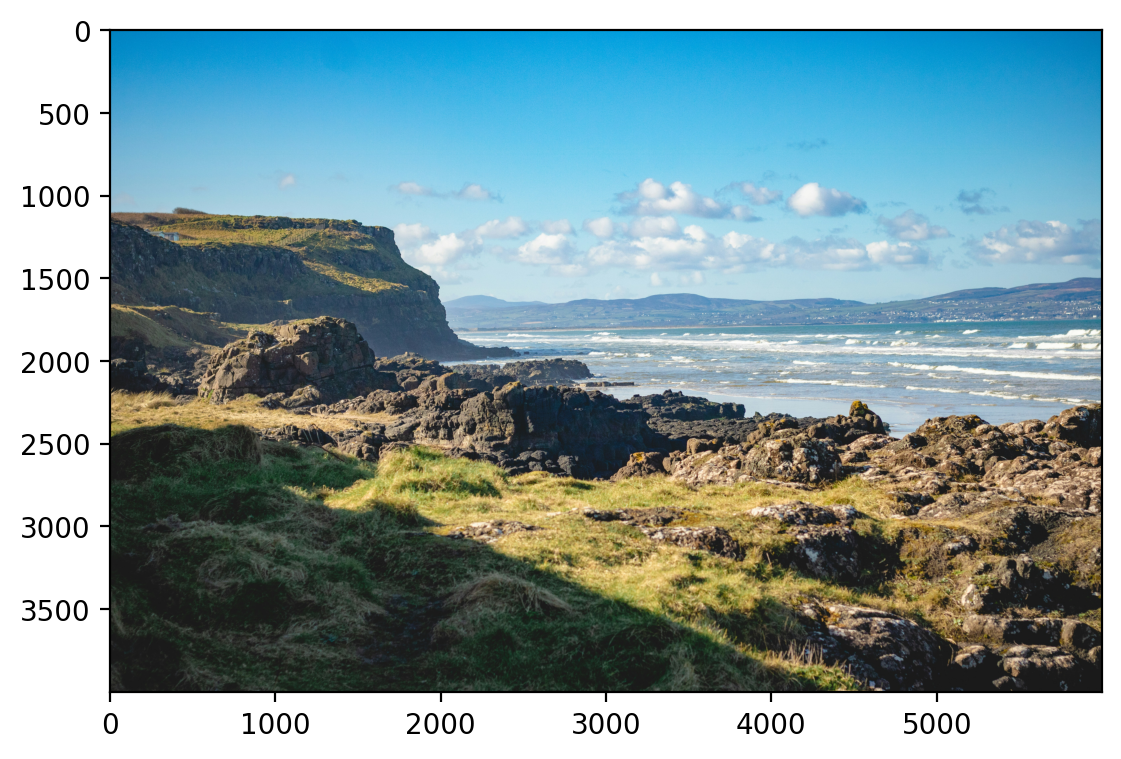

In [3]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [4]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [5]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape
img_scaled = torch.tensor(img_scaled)
img_scaled = img_scaled.to('cpu')
img_scaled.shape

torch.Size([3, 4000, 6000])

torch.Size([3, 400, 400])


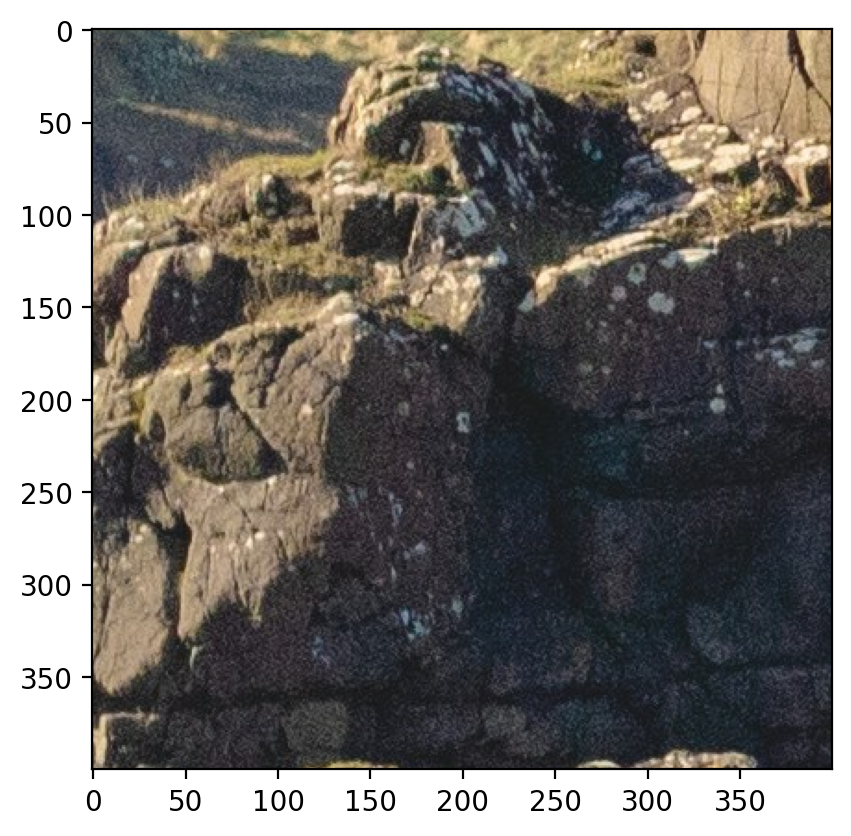

In [6]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 1800, 700, 400, 400)
print(crop.shape)
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

In [7]:
# Get the dimensions of the image tensor
num_channels, height, width = crop.shape
print(num_channels, height, width)

3 400 400


In [8]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)
    
    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """
    
    num_channels, height, width = img.shape
    
    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [9]:
img_X, img_Y = create_coordinate_map(crop)

img_X.shape, img_Y.shape

(torch.Size([160000, 2]), torch.Size([160000, 3]))

In [10]:
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(img_X.cpu())

# Scale the X coordinates
img_X_scaled = scaler_X.transform(img_X.cpu())

# Move the scaled X coordinates to the GPU
img_X_scaled = torch.tensor(img_X_scaled).to(device)

# Set to dtype float32
img_X_scaled = img_X_scaled.float()

In [11]:
img_Y_scaled = img_Y

In [12]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        
    def forward(self, x):
        return self.linear(x)
    

In [13]:
net = LinearModel(2, 3)
net.to(device)

LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [14]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 10 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

train(net, 0.01, img_X_scaled, img_Y, 1000)

Epoch 0 loss: 0.242965
Epoch 10 loss: 0.152872
Epoch 20 loss: 0.094844
Epoch 30 loss: 0.059032
Epoch 40 loss: 0.040244
Epoch 50 loss: 0.032112
Epoch 60 loss: 0.029373
Epoch 70 loss: 0.028737
Epoch 80 loss: 0.028646
Epoch 90 loss: 0.028636
Epoch 100 loss: 0.028626
Epoch 110 loss: 0.028617
Epoch 120 loss: 0.028613
Epoch 130 loss: 0.028611
Epoch 140 loss: 0.028611
Epoch 150 loss: 0.028611
Epoch 160 loss: 0.028611
Epoch 170 loss: 0.028611
Epoch 180 loss: 0.028611
Epoch 190 loss: 0.028611
Epoch 200 loss: 0.028611
Epoch 210 loss: 0.028611
Epoch 220 loss: 0.028611
Epoch 230 loss: 0.028611
Epoch 240 loss: 0.028611
Epoch 250 loss: 0.028611
Epoch 260 loss: 0.028611
Epoch 270 loss: 0.028611
Epoch 280 loss: 0.028611
Epoch 290 loss: 0.028611
Epoch 300 loss: 0.028611
Epoch 310 loss: 0.028611
Epoch 320 loss: 0.028611
Epoch 330 loss: 0.028611
Epoch 340 loss: 0.028611
Epoch 350 loss: 0.028611
Epoch 360 loss: 0.028611
Epoch 370 loss: 0.028611
Epoch 380 loss: 0.028611
Epoch 390 loss: 0.028611
Epoch 400 l

0.028611019253730774

In [15]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        predicted = img_Y.cpu().numpy()
        original = outputs.cpu().numpy()
        rmse = np.sqrt(np.mean((predicted - original) ** 2))
        print(rmse)
        psnr = 20 * np.log10(255 / rmse)
        if rmse == 0:
           psnr = float('inf')
        outputs = outputs.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
    
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title(f"Reconstructed Image\nRMSE: {rmse:.4f} PSNR: {psnr:.4f}")

    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")
    
    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

0.16914791


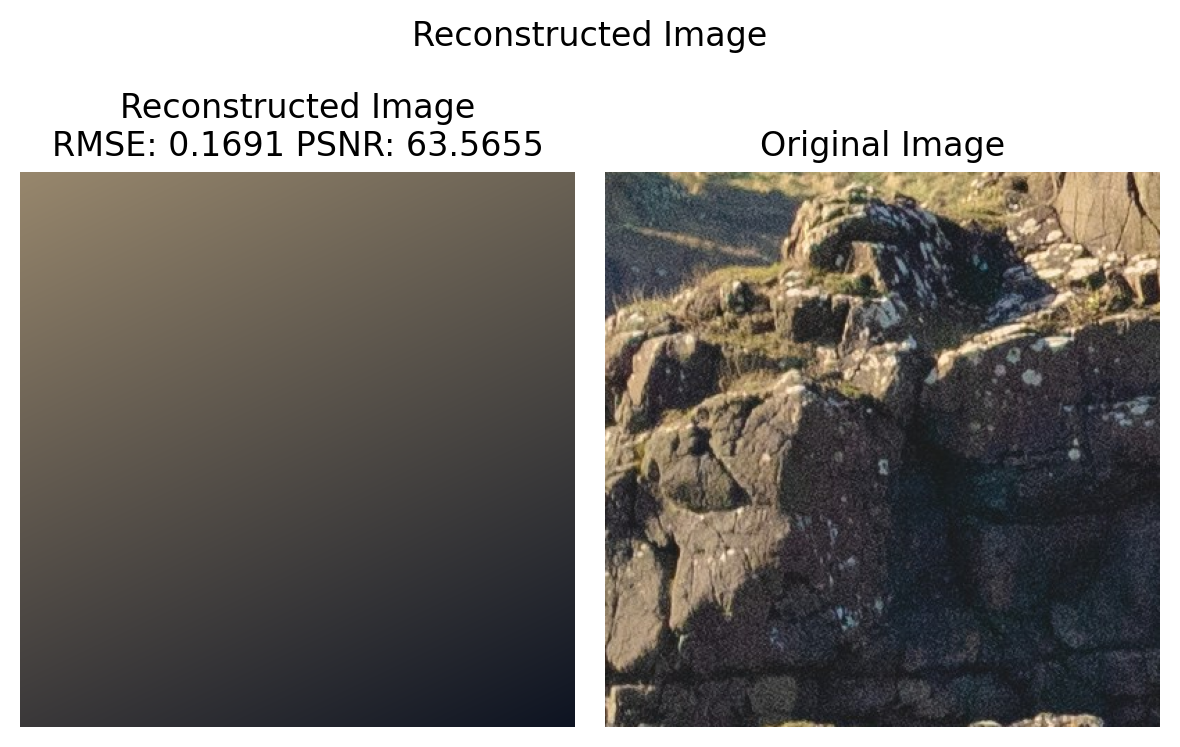

In [16]:
plot_reconstructed_and_original_image(crop, net, img_X_scaled, title="Reconstructed Image")

In [17]:
# create RFF features
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [18]:
X_rff = create_rff_features(img_X_scaled, 25000, 0.008)
X_rff.shape

torch.Size([160000, 25000])

Epoch 0 loss: 0.128057
Epoch 10 loss: 0.026305
Epoch 20 loss: 0.011483
Epoch 30 loss: 0.009789
Epoch 40 loss: 0.007536
0.077026166


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


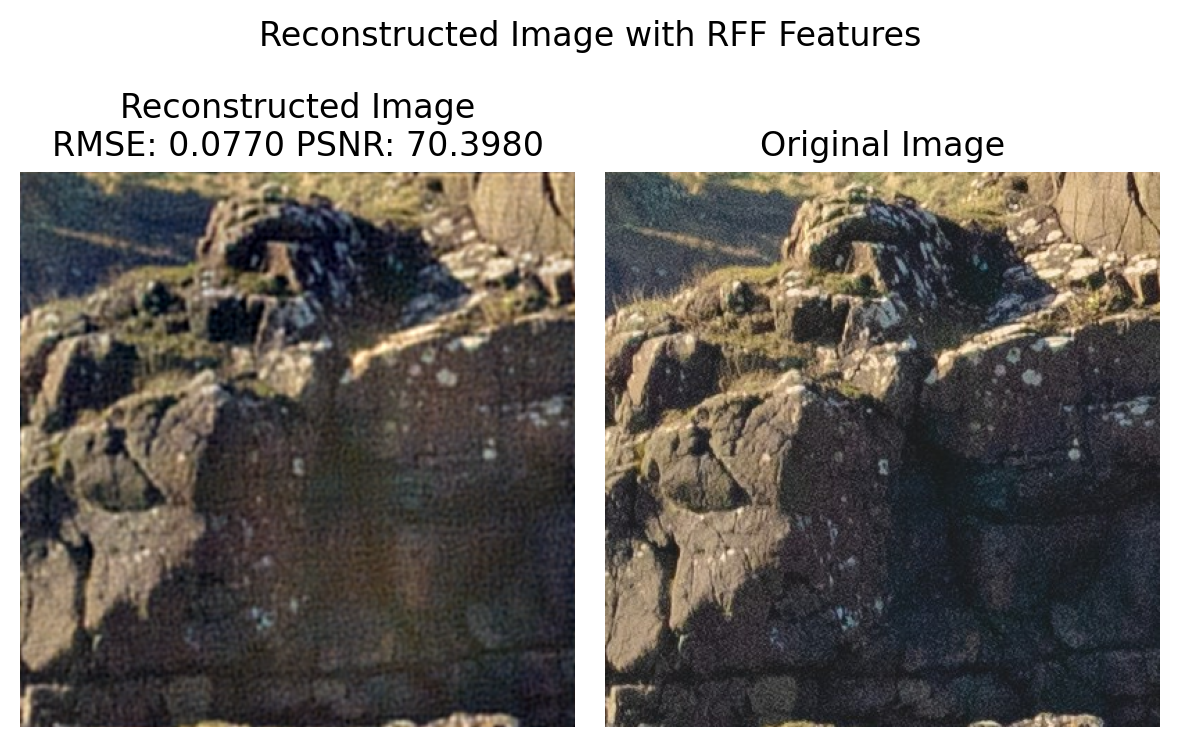

In [19]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)
train(net, 0.05, X_rff, img_Y, 50)
plot_reconstructed_and_original_image(crop, net, X_rff, title="Reconstructed Image with RFF Features")

Epoch 0 loss: 0.127508
Epoch 10 loss: 0.091341
Epoch 20 loss: 0.065064
Epoch 30 loss: 0.046360
Epoch 40 loss: 0.033820


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.16099738


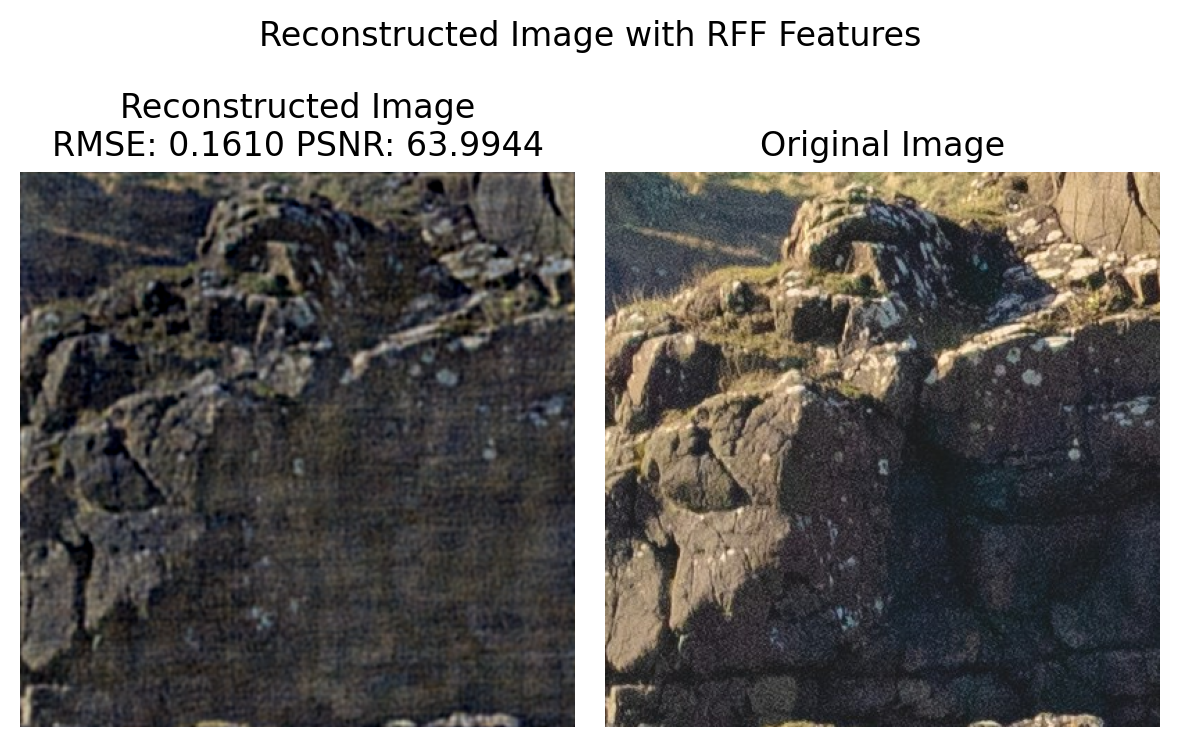

In [20]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)
train(net, 0.005, X_rff, img_Y, 50)
plot_reconstructed_and_original_image(crop, net, X_rff, title="Reconstructed Image with RFF Features")

Epoch 0 loss: 0.129730
Epoch 10 loss: 0.026248
Epoch 20 loss: 0.011468
Epoch 30 loss: 0.009900
Epoch 40 loss: 0.007564
Epoch 50 loss: 0.005929
Epoch 60 loss: 0.004999
Epoch 70 loss: 0.004364
Epoch 80 loss: 0.003879
Epoch 90 loss: 0.003502
0.05664767


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


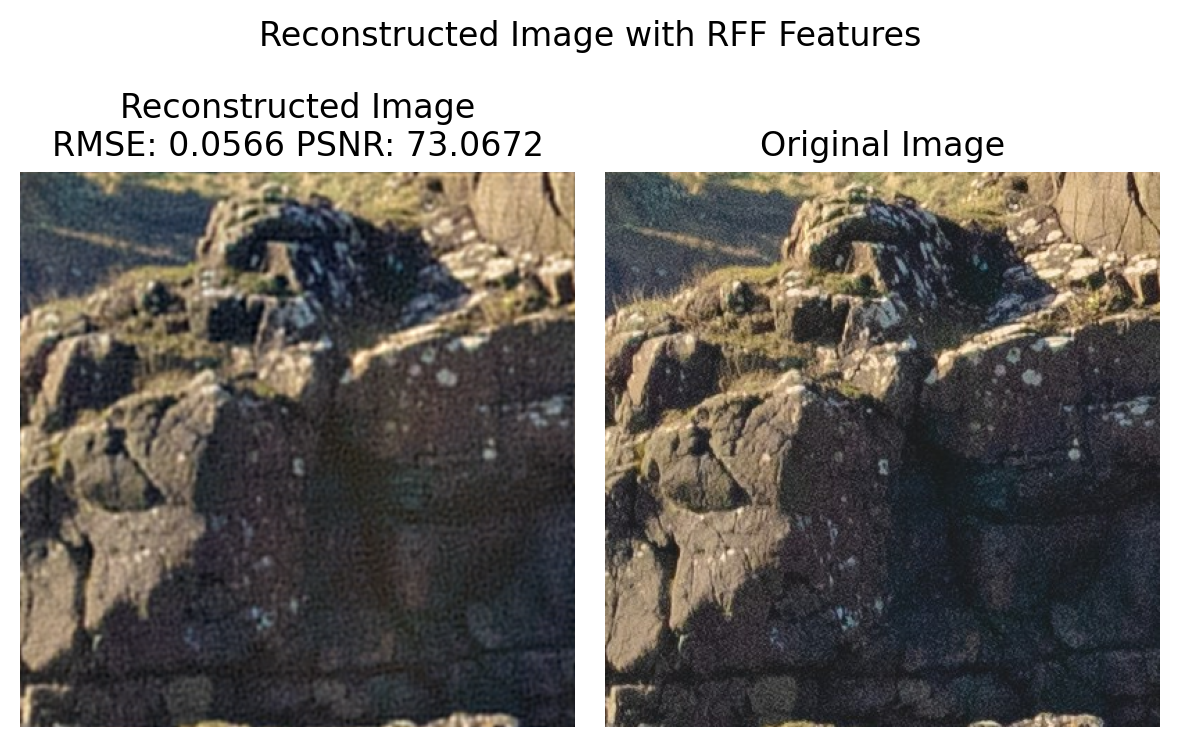

In [21]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)
train(net, 0.05, X_rff, img_Y, 100)
plot_reconstructed_and_original_image(crop, net, X_rff, title="Reconstructed Image with RFF Features")

Epoch 0 loss: 0.129866
Epoch 10 loss: 0.093288
Epoch 20 loss: 0.066604
Epoch 30 loss: 0.047513
Epoch 40 loss: 0.034626
Epoch 50 loss: 0.026442
Epoch 60 loss: 0.021494
Epoch 70 loss: 0.018565
Epoch 80 loss: 0.016783
Epoch 90 loss: 0.015607
0.121418364


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


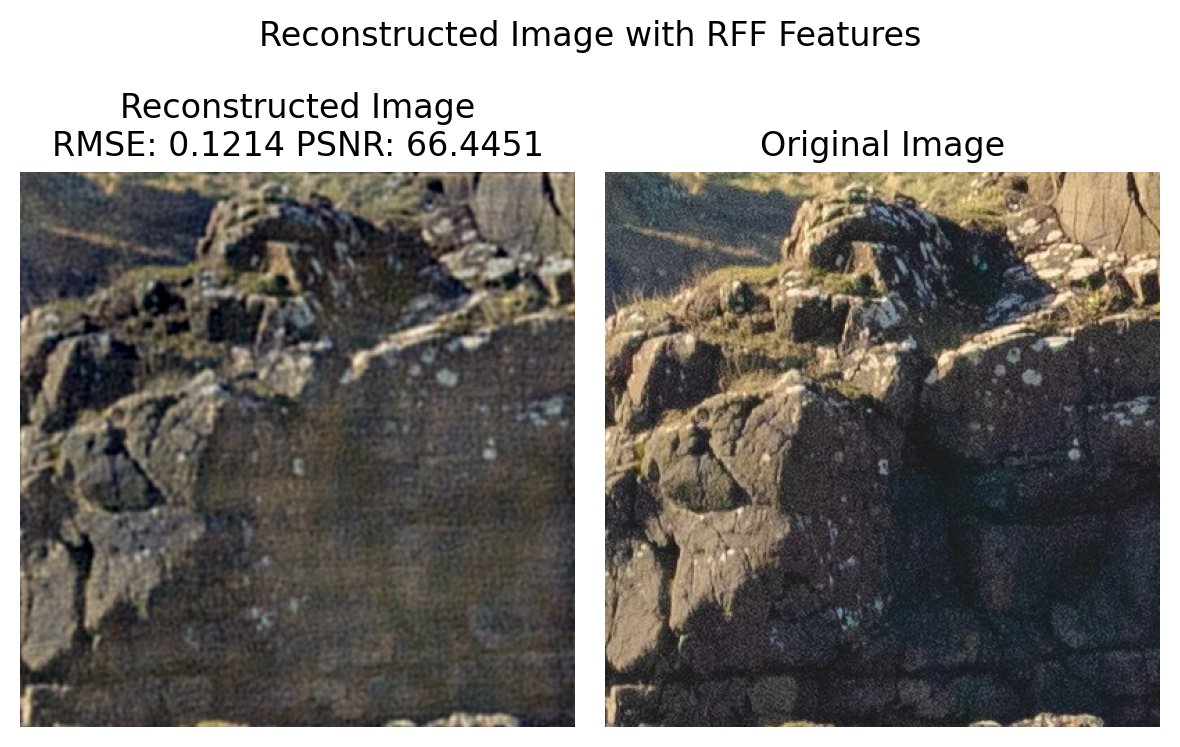

In [22]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)
train(net, 0.005, X_rff, img_Y, 100)
plot_reconstructed_and_original_image(crop, net, X_rff, title="Reconstructed Image with RFF Features")